## Zero Shot Learning
### Learning Dataset: Non-Immunodeficiency virus
### Evaluation Dataset: Immunodeficiency virus


In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/zero_shot',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/zero_shot/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/zero_shot/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/zero_shot/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/zero_shot/../..']

In [32]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [40]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}

classes=["Human", "Rhesus macaque", "Cat", "Cattle"]

def overall_auprc(output_file_paths, classes):
    auprc_results = []
    results = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        itrs = df[itr_col].unique()
        for itr in itrs:
            
            df_itr = df[df[itr_col] == itr]
            macro_auprc = compute_auprc(df_itr)
            result_itr = {"model": model, "itr": itr, "auprc": macro_auprc}
            results.append(result_itr)
    result_df = pd.DataFrame(results)
    FIGURE_CONFIG = {
        "figsize": (15, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=result_df, x="model", y="auprc", linewidth=1.5, fliersize=5)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    # sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    
    visualization_utils.wrap_xticklabels(ax)
    plt.show()
            
    
def class_wise_auprc_analysis(output_file_paths, classes, figure_output_filepath=None):
    auprc_results = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        print(f"Read output {model} = {df.shape}")

        itrs = df[itr_col].unique()
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (15, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", order=metadata_sorted, linewidth=1.5, fliersize=5)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_xticklabels(ax)
    # visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df


def compute_auprc(df_itr):
    # macro auprc = unweighted average of auprc for each class
    # only for one-vs-rest setting
    pr_curves = []
    auprcs = []
    for y_pred_column in classes:
        precision, recall, _ = precision_recall_curve(y_true=df_itr["y_true"].values, probas_pred=df_itr[y_pred_column].values, pos_label=y_pred_column)
        #pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, self.class_col: y_pred_column}))
        auprcs.append(auc(recall, precision))

    return mean(auprcs)

In [41]:
output_file_paths = {
    # "FNN": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_idv_common_hosts_non_idv_t0.005_c4/20240528/host_multi/emb_sincos-lossfocalce_e50_msl1366_fnn-l_10-d_1024-lr1e-3_output.csv"),
    "CNN": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_idv_common_hosts_non_idv_t0.005_c4/20240528/host_multi/emb_sincos-lossfocalce_e50_msl1366_cnn-l_4-d_1024-k3s1-lr1e-3_output.csv"),
    "RNN": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_idv_common_hosts_non_idv_t0.005_c4/20240528/host_multi/emb_sincos-lossfocalce_e50_msl1366_rnn-l_6-d_1024-lr1e-5_output.csv"),
    "LSTM": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_idv_common_hosts_non_idv_t0.005_c4/20240528/host_multi/emb_sincos-lossfocalce_e50_msl1366_lstm-l_2-d_1024-lr1e-3_output.csv"),
    "TF-Enc": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_idv_common_hosts_non_idv_t0.005_c4/20240528/host_multi/emb_sincos-lossfocalce_e50_msl1366_transformer-l_6-h_8-d_1024-lr1e-4_output.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_idv_common_hosts_non_idv_t0.005_c4/20240528/host_multi/fine_tuning/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv")
}

Read output CNN = (14785, 6)
Read output RNN = (14785, 6)
Read output LSTM = (14785, 6)
Read output TF-Enc = (14785, 6)
Read output VirProBERT = (14785, 6)


<Figure size 432x288 with 0 Axes>

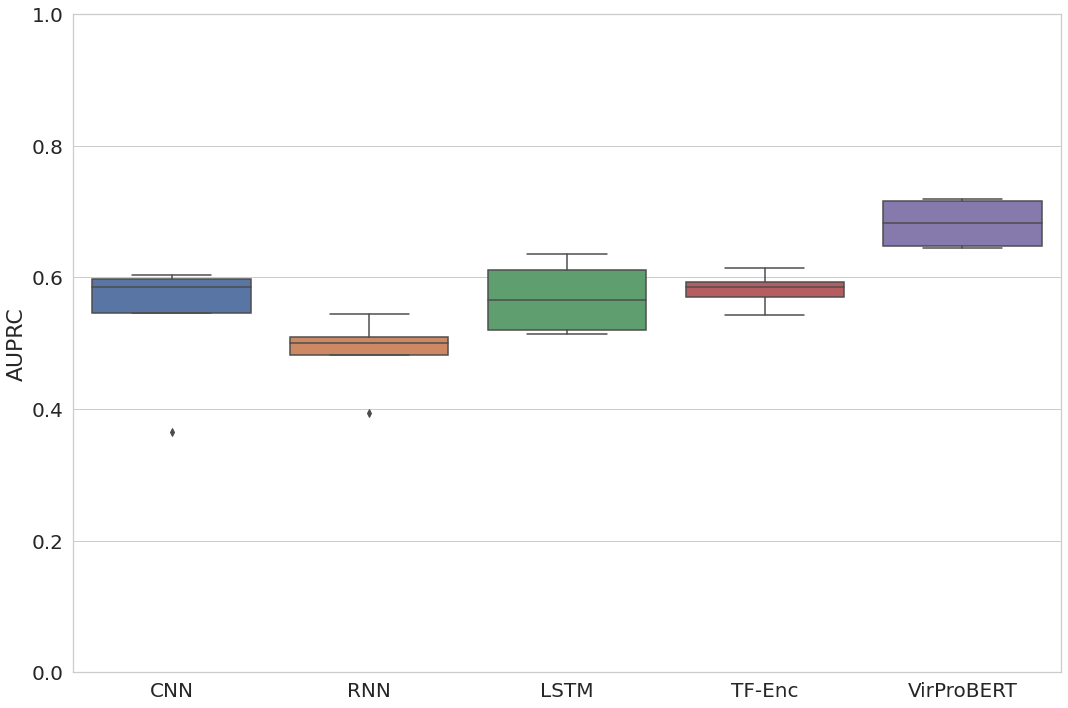

In [42]:
overall_auprc(output_file_paths, classes)

Read output CNN = (14785, 6)
Read output RNN = (14785, 6)
Read output LSTM = (14785, 6)
Read output TF-Enc = (14785, 6)
Read output VirProBERT = (14785, 6)


<Figure size 432x288 with 0 Axes>

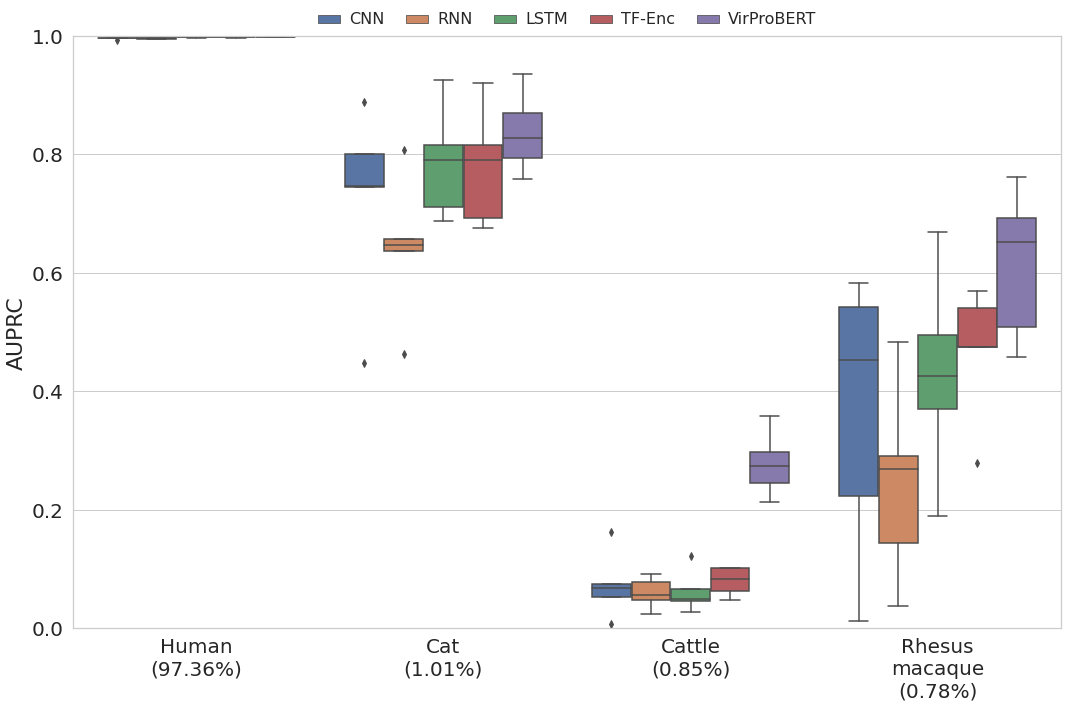

,class,auprc,model,itr
0,Human (97.36%),0.997480,CNN,0
1,Rhesus macaque (0.78%),0.452769,CNN,0
2,Cat (1.01%),0.888787,CNN,0
3,Cattle (0.85%),0.075388,CNN,0
4,Human (97.36%),0.992913,CNN,1
...,...,...,...,...
95,Cattle (0.85%),0.246107,VirProBERT,3
96,Human (97.36%),0.998921,VirProBERT,4
97,Rhesus macaque (0.78%),0.762470,VirProBERT,4
98,Cat (1.01%),0.758230,VirProBERT,4


In [31]:
class_wise_auprc_analysis(output_file_paths, classes)